## OptiWaste: Integrating Operations Research Techniques for Enhanced Decision Support in Waste Management

In [1]:
# importing the libraries
import geopandas as gpd
import pulp
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
import numpy as np


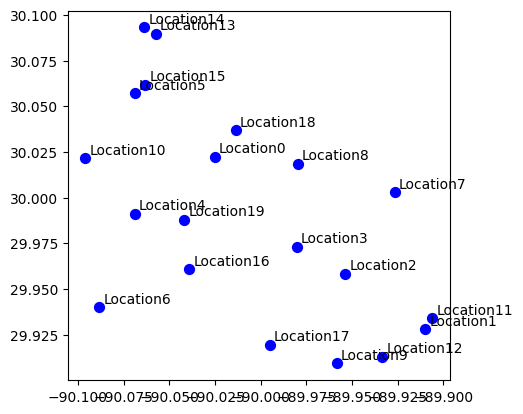

In [2]:
# Seed for reproducibility
np.random.seed(42)

# Generate random points within a coordinate grid
x_coords = np.random.uniform(-90.1, -89.9, 20)
y_coords = np.random.uniform(29.9, 30.1, 20)
locations = ['Location'+str(i) for i in range(20)]

# Create a GeoDataFrame
df = pd.DataFrame({'Location': locations, 'Coordinates': list(zip(x_coords, y_coords))})
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy([coord[0] for coord in df['Coordinates']],
                                                       [coord[1] for coord in df['Coordinates']]))

# Plotting the locations
fig, ax = plt.subplots()
gdf.plot(ax=ax, color='blue', marker='o', markersize=50)
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['Location']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
plt.show()


In [3]:
from scipy.spatial import distance_matrix

# Create a distance matrix
coords = list(zip(gdf.geometry.x, gdf.geometry.y))
dist_matrix = distance_matrix(coords, coords)

# Create a distance dictionary suitable for the optimization model
distances = {(i, j): dist_matrix[i][j] for i in range(len(coords)) for j in range(len(coords)) if i != j}


In [4]:
# Create a problem variable:
prob = pulp.LpProblem("ComplexCityWasteCollection", pulp.LpMinimize)

# Create variables for each route:
routes = pulp.LpVariable.dicts("Route", distances, 0, 1, pulp.LpBinary)

# Objective function: Minimize the total distances travelled
prob += pulp.lpSum([distances[(i, j)] * routes[(i, j)] for (i, j) in distances]), "Total_Distance"

# Constraints:
# Ensure that each location is visited exactly once coming and going
for location in range(len(coords)):
    prob += pulp.lpSum([routes[(i, j)] for i, j in routes if j == location]) == 1, f"Enter_{location}"
    prob += pulp.lpSum([routes[(i, j)] for i, j in routes if i == location]) == 1, f"Exit_{location}"

# Solve the problem
prob.solve()

# Output the results:
print("Status:", pulp.LpStatus[prob.status])
for v in prob.variables():
    if v.varValue == 1:
        print(v.name, "=", v.varValue)

# Print the optimized total distance
print("Optimized Total Distance: ", pulp.value(prob.objective))


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/17/xvl07b2n1kq7qscwxp63zc680000gn/T/12d1b979e0b84b1a85ef8892cfca2369-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/17/xvl07b2n1kq7qscwxp63zc680000gn/T/12d1b979e0b84b1a85ef8892cfca2369-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 45 COLUMNS
At line 1946 RHS
At line 1987 BOUNDS
At line 2368 ENDATA
Problem MODEL has 40 rows, 380 columns and 760 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.605537 - 0.00 seconds
Cgl0004I processed model has 40 rows, 380 columns (380 integer (380 of which binary)) and 760 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 0.605537
Cbc0038I Before mini branch and

In [5]:
# Extracting the solution and preparing data for plotting
routes_used = [(i, j) for i, j in routes if pulp.value(routes[(i, j)]) == 1]
print("Routes used:", routes_used)

# Create a simple function to draw lines between points
def plot_route(ax, start_point, end_point, color='b'):
    ax.plot([start_point.x, end_point.x], [start_point.y, end_point.y], color=color, linewidth=2, marker='o')

# Get the coordinates of the routes
route_coords = [(gdf.geometry.iloc[i], gdf.geometry.iloc[j]) for i, j in routes_used]


Routes used: [(0, 18), (1, 11), (2, 3), (3, 2), (4, 10), (5, 15), (6, 19), (7, 8), (8, 7), (9, 17), (10, 4), (11, 1), (12, 9), (13, 14), (14, 13), (15, 5), (16, 6), (17, 12), (18, 0), (19, 16)]


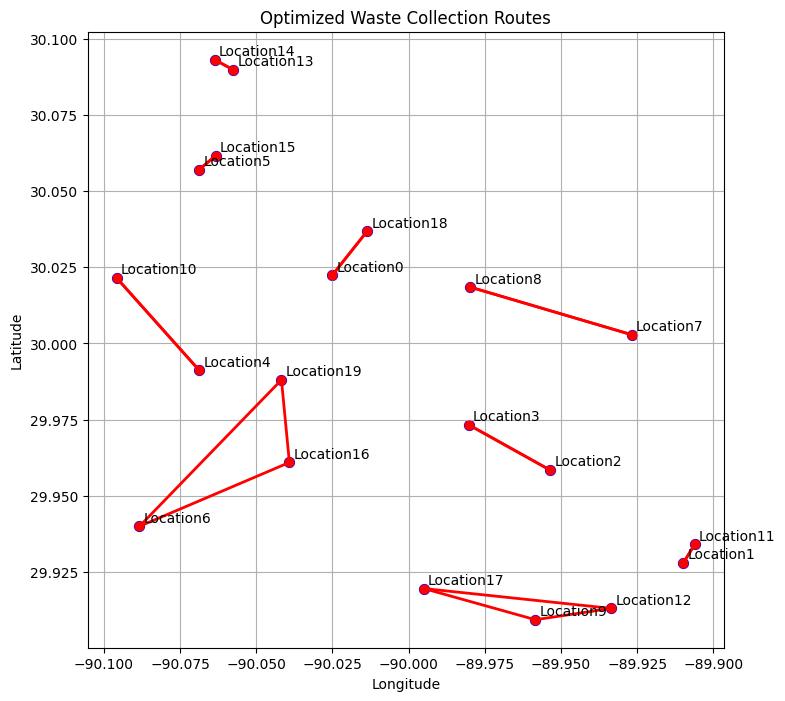

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each point
gdf.plot(ax=ax, color='blue', marker='o', markersize=50)

# Annotate each point
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['Location']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

# Plot the routes
for start_point, end_point in route_coords:
    plot_route(ax, start_point, end_point, color='red')

plt.title('Optimized Waste Collection Routes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()
